# Racetrack example
from *Reinforcement learning - An introduction* book, chapter 5, Exercice 5.8

**Racetrack**. Consider driving a race car around a turn like those shown in Figure 5.6. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set
of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in one step, for a total of nine actions. Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are −1 for each step
until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

- States : position (x,y) on the grid and velocity (vx, vy)
- Actions : vx, vy velocity increments (+1,-1,0) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.getLogger().setLevel(logging.DEBUG)

First we define a race track similar as in the exercise

In [2]:
TRACK_WIDTH = 25
TRACK_HEIGTH = 60

TRACK = {}
TRACK['grid'] = np.ones((TRACK_HEIGTH, TRACK_WIDTH))

# Starting line:
TRACK['starting_line'] = ((0, 7), (0,15))
sl = TRACK['starting_line']
TRACK['grid'][TRACK_HEIGTH - 1 - sl[0][0], sl[0][1]:sl[1][1]] = 0.5

# Finish line:
TRACK['finish_line'] = ((TRACK_HEIGTH, TRACK_WIDTH-1), (TRACK_HEIGTH-10, TRACK_WIDTH-1))
fl = TRACK['finish_line']
TRACK['grid'][TRACK_HEIGTH - fl[0][0]:TRACK_HEIGTH - fl[1][0], fl[0][1]] = 0.5

# Off-track:
for i in range(TRACK_WIDTH):
    for j in range(TRACK_HEIGTH):
        if i + j < 7:
            TRACK['grid'][j, i] = 0.0
        elif i >= 15 and j >= 10:
            TRACK['grid'][j, i] = 0.0
        elif i <= 7 and j >= TRACK_HEIGTH/2.2 and i + 0.2*(TRACK_HEIGTH-j) <= 7:
            TRACK['grid'][j, i] = 0.0

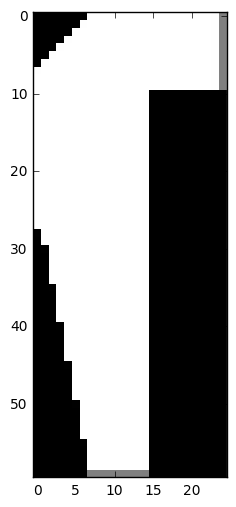

In [3]:
plt.figure(figsize=(14,6))
plt.imshow(TRACK['grid'], cmap='gray', interpolation='None')

Below we define useful functions to work with states and actions and some helper functions.
In the episode generating method `race`, we do not implement finish and off-track checks by the intersection, we simply check if final state is at the finish or off-track. This leads in some cases to non-finishing and fly-over boundaries trajectories.

In [4]:
def position_in_interval(x,y,(x1,y1,x2,y2)):
    v1 = (x - x1, y - y1)
    v2 = (x2 - x, y2 - y)
    v3 = (x2 - x1, y2 - y1)
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    c = np.dot(v1, v2) if n1 > 0 and n2 > 0 else 1.0
    n3 = np.linalg.norm(v3)
    return n1 + n2 == n3 and c >= 0

def get_actions(state, track):
    """
    Method to get all available actions for the current state
    :state: (x, y, vx, vy)
    :return: list of actions, e.g. [[dvx, dvy], ...]
    """    
    x,y,vx,vy = state
    actions = []
    for dvx in range(-1,2):
        for dvy in range(-1,2):
            nvx = vx + dvx; nvy = vy + dvy
            if 0 < nvx < 5 and 0 < nvy < 5:
                actions.append([dvx, dvy])
            elif 0 < nvx < 5 and 0 == nvy or 0 < nvy < 5 and 0 == nvx:
                actions.append([dvx, dvy])
            elif 0 == nvx and 0 == nvy:
                if track['grid'][TRACK_HEIGTH-1-y, x] == 0.5:
                    actions.append([dvx, dvy])
    assert len(actions) > 0, "No actions found for the state : {}".format(state)
    return actions

def take_action(state, action):
    x, y, vx, vy = state
    nx = x + vx
    ny = y + vy
    nvx = vx + action[0]
    nvy = vy + action[1]
    return (nx, ny, nvx, nvy)

In [6]:
def get_initial_state(track, alpha):
    [y1, x1], [y2, x2] = track['starting_line']
    v = (x2 - x1, y2 - y1)
    return (int(x1 + v[0] * alpha), int(y1 + v[1] * alpha), 0, 0)

def at_start(x, y, track):
    sl = track['starting_line']
    return position_in_interval(x,y,(sl[0][1], sl[0][0], sl[1][1], sl[1][0]))

def at_finish(x, y, track):
    fl = track['finish_line']
    return position_in_interval(x,y,(fl[0][1], fl[0][0], fl[1][1], fl[1][0]))

def distance_to_finish(x, y, track):
    fl = track['finish_line']
    finish_point = (int(fl[1][1] + 0.5*(fl[0][1]-fl[1][1])), int(fl[1][0] + 0.5*(fl[0][0]-fl[1][0])))
    return np.abs(finish_point[0] - x) + np.abs(finish_point[1] - y)

def is_off_track(x, y, track):
    return x < 0 or y < 0 or x >= TRACK_WIDTH or y >= TRACK_HEIGTH or track['grid'][TRACK_HEIGTH-1-y, x] < 0.5
    

MIN_REWARD = -(TRACK_HEIGTH + TRACK_WIDTH)  
CRASH_REWARD = MIN_REWARD*0.15
REACHED_FINISH_REWARD = 100
    
def race(policy_func, track, initial_state=None):
    
    logging.debug("-- Race is called : initial_state={}".format(initial_state))
    
    if initial_state is None:
        initial_state = get_initial_state(track, alpha=np.random.rand())
        
    # define a function when car is at finish
    fl = track['finish_line']

    trajectory = []
    reward = 0
    state = initial_state
    reached_finish = False
    while reward > MIN_REWARD and not reached_finish:

        action = policy_func(state)
        trajectory.append((state, action))
        
        logging.debug("--- Race loop : state={}, action={}, reward={}, len(trajectory)={}".format(state, action, reward, len(trajectory)))
        
        state = take_action(state, action)
        logging.debug("--- Race loop 2 : new state={}".format(state))
        x, y, vx, vy = state
        if is_off_track(x, y, track):
            logging.debug("--- Race loop 3 : out of track")
            reward = CRASH_REWARD
            break

        reward -= 1
        reached_finish = at_finish(state[0], state[1], track)
    
    if reached_finish:
        reward += REACHED_FINISH_REWARD
        
    return reward, trajectory, reached_finish

In [7]:
from operator import itemgetter

def find_best_trajectory(initial_state, q_state_action, track):
    state = initial_state
    reward = 0
    reached_finish = False
    trajectory = []
    while not reached_finish or is_off_track(state[0], state[1], track):
        actions_values = q_state_action[state]
        action = actions_values[0][0]
        state = take_action(state, action)
        reward -= 1
        reached_finish = at_finish(state[0], state[1], track)
        trajectory.append(state)
        
    return trajectory, reward, reached_finish

def draw_trajectory(trajectory, track, fig=None):
    if fig is None:
        plt.figure(figsize=(12,4))
    plt.imshow(track['grid'], cmap='gray', interpolation='None')
    xs = []
    ys = []
    us = []
    vs = []
    for state, action in trajectory:
        xs.append(state[0])
        ys.append(TRACK_HEIGTH - 1 - state[1])
        us.append(state[2])
        vs.append(state[3])
    plt.quiver(xs, ys, us, vs)
    
    
def draw_q_state_action(q_state_action, track):
    plt.figure(figsize=(12,6))
    plt.imshow(track['grid'], cmap='gray', interpolation='None')
    xs = []; ys = []; us1 = []; vs1 = []; us2 = []; vs2 = []
    for state in q_state_action:
        xs.append(state[0])
        ys.append(TRACK_HEIGTH - 1 - state[1])
        us1.append(state[2])
        vs1.append(state[3])
    plt.quiver(xs, ys, us1, vs1)        

We also define a behavior policy that selects the best action for a known state, otherwise it picks a random action such that: 
- car keeps moving
- distance to finish decrease
- car does not go off the track

In [25]:
def random_behavior_policy(state, track):
    index = 0
    actions = get_actions(state, track)
    count = len(actions)
    prev_dist = distance_to_finish(state[0], state[1], track)
    while count > 0:
        index = np.random.randint(len(actions))
        action = actions[index]
        x,y,vx,vy = take_action(state, action)
        nx, ny = x + vx + action[0], y + vy + action[1]
        new_dist = distance_to_finish(nx, ny, track)
        if vx > 0 or vy > 0 and new_dist < prev_dist and not is_off_track(nx, ny, track):
            break
        count -= 1
    return actions[index]

def behavior_policy(state, track, q_state_action):
    if state in q_state_action:
        actions_values = q_state_action[state]
        return actions_values[0][0]
    else:
        return random_behavior_policy(state, track)

Now we define some policy parameters and now we can start racing and policy learning

First, we implement *Monte Carlo Exploring Starts* method

```
Initialize, for all s ∈ S, a ∈ A(s):
    Q(s, a) ← arbitrary
    π(s) ← arbitrary
    Returns(s, a) ← empty list
    
Repeat forever:
    Choose S_0 ∈ S and A_0 ∈ A(S_0) s.t. all pairs have probability > 0
    Generate an episode starting from S_0 , A_0 , following π
    For each pair s, a appearing in the episode:
        G ← return following the first occurrence of s, a
        Append G to Returns(s, a)
        Q(s, a) ← average(Returns(s, a))
    For each s in the episode:
        π(s) ← argmax_a Q(s, a)
```

*Note on the implementation*
- The initialization part is done in the `behavior_policy` if the input state is not known.


In [60]:
from collections import defaultdict

def monte_carlo_es(n_episodes=1000, track=TRACK, q_state_action=None):
    
    q_state_action = {} if q_state_action is None else q_state_action
    
    finished_race_count = 0
    best_reward = MIN_REWARD
    policy_func = lambda state: behavior_policy(state, track, q_state_action)
    
    for episode in range(n_episodes):
        if episode % 1000 == 0:
            logging.info("Episode : %i" % episode)
        
        # Policy evaluation:
        logging.debug("- Policy evaluation")
        initial_state = get_initial_state(track, alpha=np.random.rand())
        reward, trajectory, reached_finish = race(policy_func, track, initial_state)

        if reached_finish:
            finished_race_count += 1
            if best_reward < reward:
                best_reward = reward
#             logging.info("Reward: {} | start_state={}, last_state={}".format(reward, trajectory[0][0],  trajectory[-1][0]))
#             draw_trajectory(trajectory, track)
            
        # Policy improvement:
        logging.debug("- Policy improvement")
        first_occurence = defaultdict(list)
        for (state, action) in trajectory:
            if not action in first_occurence[state]:
                first_occurence[state].append(action)
                if state in q_state_action:
                    actions_values = q_state_action[state]
                    for action_value in actions_values:
                        if action_value[0] == action:
                            action_value[1] += reward
                    q_state_action[state] = sorted(actions_values, key=itemgetter(1), reverse=True)
                else:
                    # Generate arbitrary state action values:
                    actions = get_actions(state, track)
                    actions_values = []
                    for a in actions:
                        if a == action:
                            actions_values.append([a, reward])
                        elif at_start(state[0], state[1], track) and a == [0, 0]:
                            actions_values.append([a, MIN_REWARD*10])
                        else:
                            actions_values.append([a, np.random.randint(MIN_REWARD*0.75, MIN_REWARD*0.55)])

                    actions_values = sorted(actions_values, key=itemgetter(1), reverse=True)
                    q_state_action[state] = actions_values                                

    logging.info("Finished racing: {} / {}, best reward: {}".format(finished_race_count, n_episodes, best_reward))
    return q_state_action, finished_race_count, best_reward

In [61]:
MIN_REWARD = -(TRACK_HEIGTH + TRACK_WIDTH)  
CRASH_REWARD = MIN_REWARD*0.65
REACHED_FINISH_REWARD = 30

q_state_action = {}

INFO:root:Episode : 0
INFO:root:Episode : 1000
INFO:root:Episode : 2000
INFO:root:Episode : 3000
INFO:root:Episode : 4000
INFO:root:Episode : 5000
INFO:root:Episode : 6000
INFO:root:Episode : 7000
INFO:root:Episode : 8000
INFO:root:Episode : 9000
INFO:root:Finished racing: 4559 / 10000, best reward: 9


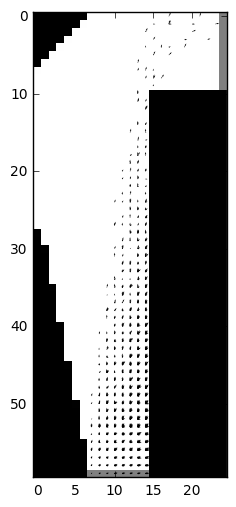

In [62]:
logging.getLogger().setLevel(logging.INFO)       
q_state_action, finished_race_count, best_reward = monte_carlo_es(10000, q_state_action=q_state_action)
draw_q_state_action(q_state_action, TRACK)

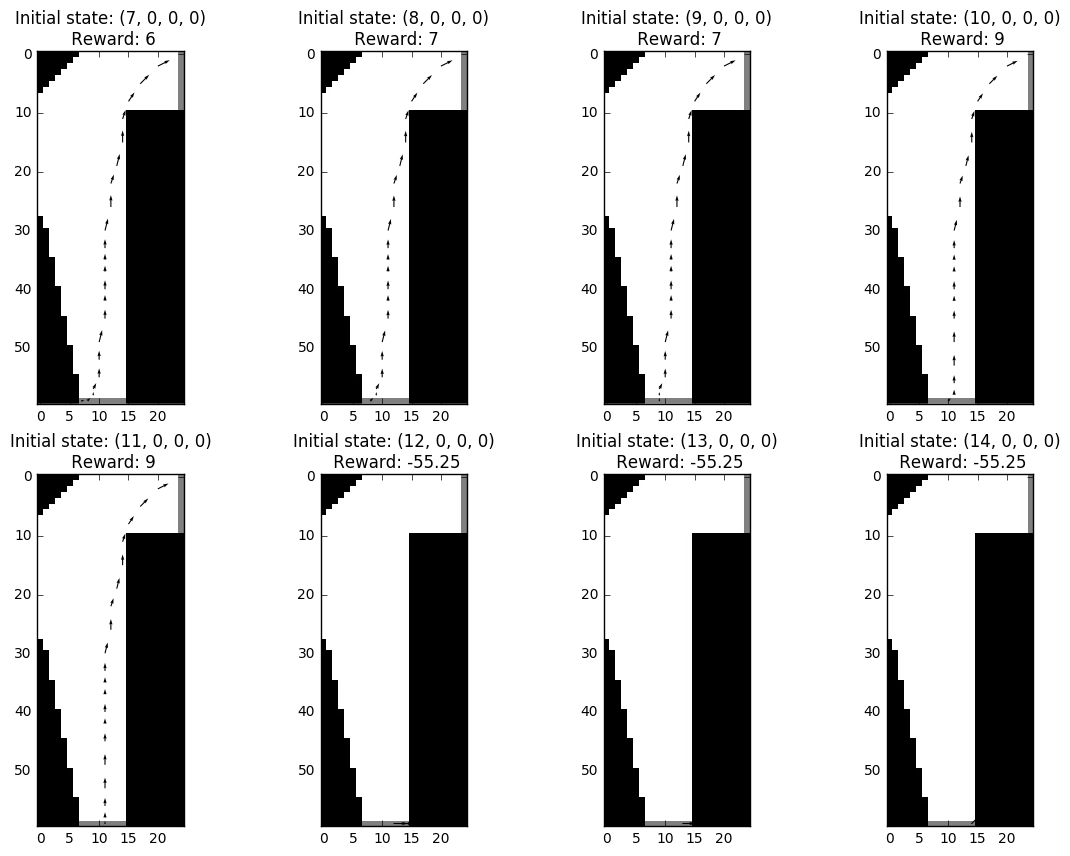

In [63]:
fig = plt.figure(figsize=(14,10))
n_figs = 8
for i in range(0, n_figs):
    alpha = i*1.0 / n_figs
    state = get_initial_state(TRACK, alpha)
    policy_func = lambda state: behavior_policy(state, TRACK, q_state_action)
    
    reward, best_trajectory, reached_finish = race(policy_func, TRACK, state)
    plt.subplot(2, n_figs/2, i+1)
    plt.title("Initial state: {}\n Reward: {}".format(state, reward))
    draw_trajectory(best_trajectory, TRACK, fig)                

Next we implements *on-policy first-visit Monte Carlo* method

```
Initialize, for all s ∈ S, a ∈ A(s):
    Q(s, a) ← arbitrary
    Returns(s, a) ← empty list
    π(a|s) ← an arbitrary ε-soft policy

Repeat forever:
    (a) Generate an episode using π
    (b) For each pair s, a appearing in the episode:
            G ← return following the first occurrence of s, a
            Append G to Returns(s, a)
            Q(s, a) ← average(Returns(s, a))
    (c) For each s in the episode:
            A^∗ ← arg max a Q(s, a)
            For all a ∈ A(s):
               π(a|s) = { 1 − ε + ε/|A(s)|, if a = A^∗,
                        { ε/|A(s)|, if a != A^∗
```

In [ ]:
# def epsilon_soft_policy(state, track, pi_state_action, epsilon):
#     actions = get_actions(state, track)
    
#     for 
    
#     if state in q_state_action:
#         actions_values = q_state_action[state]
#         action_star = actions_values[0][0]
#         actions = get_actions(state, track)
#         for action in actions:
            
#         return 
#     else:
#         return random_behavior_policy(state, track)

In [ ]:
# def monte_carlo_on_policy(n_episodes=1000, track=TRACK, q_state_action=None, epsilon=0.1):
    
#     q_state_action = {} if q_state_action is None else q_state_action
    
#     finished_race_count = 0
#     best_reward = MIN_REWARD
#     policy_func = lambda state, track: epsilon_soft_policy(state, track, q_state_action, epsilon)
    
#     for episode in range(n_episodes):
#         if episode % 1000 == 0:
#             logging.info("Episode : %i" % episode)
        
#         # Policy evaluation:
#         logging.debug("- Policy evaluation")
#         initial_state = get_initial_state(track, alpha=np.random.rand())
#         reward, trajectory, reached_finish = race(policy_func, track, initial_state)

#         if reached_finish:
#             finished_race_count += 1
#             if best_reward < reward:
#                 best_reward = reward
# #             logging.info("Reward: {} | start_state={}, last_state={}".format(reward, trajectory[0][0],  trajectory[-1][0]))
# #             draw_trajectory(trajectory, track)
            
#         # Policy improvement:
#         logging.debug("- Policy improvement")
#         first_occurence = defaultdict(list)
#         for (state, action) in trajectory:
#             actions_values = q_state_action[state]
#             for action_value in actions_values:
#                 if action_value[0] == action:
#                     if not action in first_occurence[state]:
#                         first_occurence[state].append(action)
#                         action_value[1] += reward
#             q_state_action[state] = sorted(actions_values, key=itemgetter(1), reverse=True)

#     logging.info("Finished racing: {} / {}, best reward: {}".format(finished_race_count, n_episodes, best_reward))
#     return q_state_action, finished_race_count, best_reward

In [ ]:
def get_line_coeff(x1, y1, x2, y2):
    s = x2 - x1 
    c = y1 - y2 
    d = x1 * y2 - y1 * x2
    return (c, s, d)


def position_on_line(x,y,line_coeff):
    assert len(line_coeff) == 3, "Line coefficients are (cos, sin, dist)"
    return np.dot((x, y, 1), line_coeff) == 0